In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [32]:
data_path = '../data/'

In [33]:
#create dataframe with closing price values 
df0 = pd.read_csv(data_path+'sp500_closefull.csv', index_col=0, parse_dates=True)
#drop rows with all missing values
df0.dropna(axis=0, how='all', inplace=True)
#drop columns with 1 missing value (avoid back or foward filling for now)
df0.dropna(axis=1, how='any', inplace=True)

In [34]:
#create dataframe for returns
df_returns = pd.DataFrame()
for name in df0.columns:
  df_returns[name] = np.log(df0[name]).diff()

In [35]:
# split into train and test
Ntest = 1000
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

In [36]:
#specify input features
feats = ['AAPL', 'MSFT', 'AMZN']

In [37]:
#create environments
class Env:
  def __init__(self, df):
    self.df = df
    self.n = len(df)
    self.current_idx = 0
    self.action_space = [0, 1, 2] # BUY, SELL, HOLD
    self.invested = 0

    self.states = self.df[feats].to_numpy()
    self.rewards = self.df['SPY'].to_numpy()

  def reset(self):
    self.current_idx = 0
    return self.states[self.current_idx]

  def step(self, action):
    # need to return (next_state, reward, done)

    self.current_idx += 1
    if self.current_idx >= self.n:
      raise Exception("Episode already done")

    if action == 0: # BUY
      self.invested = 1
    elif action == 1: # SELL
      self.invested = 0
    
    # compute reward
    if self.invested:
      reward = self.rewards[self.current_idx]
    else:
      reward = 0

    # state transition
    next_state = self.states[self.current_idx]

    done = (self.current_idx == self.n - 1)
    return next_state, reward, done

In [38]:
class StateMapper:
  def __init__(self, env, n_bins=6, n_samples=10000):
    # first, collect sample states from the environment
    states = []
    done = False
    s = env.reset()
    self.D = len(s) # number of elements we need to bin
    states.append(s)
    while True:
      a = np.random.choice(env.action_space)
      s2, _, done = env.step(a)
      states.append(s2)
      if len(states) >= n_samples:
        break
      if done:
        s = env.reset()
        states.append(s)
        if len(states) >= n_samples:
          break

    # convert to numpy array for easy indexing
    states = np.array(states)

    # create the bins for each dimension
    self.bins = []
    for d in range(self.D):
      column = np.sort(states[:,d])

      # find the boundaries for each bin
      current_bin = []
      for k in range(n_bins):
        boundary = column[int(n_samples / n_bins * (k + 0.5))]
        current_bin.append(boundary)

      self.bins.append(current_bin)


  def transform(self, state):
    x = np.zeros(self.D)
    for d in range(self.D):
      x[d] = int(np.digitize(state[d], self.bins[d]))
    return tuple(x)


  def all_possible_states(self):
    list_of_bins = []
    for d in range(self.D):
      list_of_bins.append(list(range(len(self.bins[d]) + 1)))
    # print(list_of_bins)
    return itertools.product(*list_of_bins)

In [39]:
class Agent:
  def __init__(self, action_size, state_mapper):
    self.action_size = action_size
    self.gamma = 0.8  # discount rate
    self.epsilon = 0.1
    self.learning_rate = 1e-1
    self.state_mapper = state_mapper

    # initialize Q-table randomly
    self.Q = {}
    for s in self.state_mapper.all_possible_states():
      s = tuple(s)
      for a in range(self.action_size):
        self.Q[(s,a)] = np.random.randn()

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)

    s = self.state_mapper.transform(state)
    act_values = [self.Q[(s,a)] for a in range(self.action_size)]
    return np.argmax(act_values)  # returns action

  def train(self, state, action, reward, next_state, done):
    s = self.state_mapper.transform(state)
    s2 = self.state_mapper.transform(next_state)

    if done:
      target = reward
    else:
      act_values = [self.Q[(s2,a)] for a in range(self.action_size)]
      target = reward + self.gamma * np.amax(act_values)

    # Run one training step
    self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])

In [40]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return total_reward

In [41]:
num_episodes = 500

In [42]:
train_env = Env(train_data)
test_env = Env(test_data)

In [43]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

In [44]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [45]:
for e in range(num_episodes):
  r = play_one_episode(agent, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tmp_epsilon = agent.epsilon
  agent.epsilon = 0.
  tr = play_one_episode(agent, test_env, is_train=False)
  agent.epsilon = tmp_epsilon
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.5f}, test: {tr:.5f}")

eps: 1/500, train: 0.32119, test: -0.14112
eps: 2/500, train: 0.50201, test: -0.10684
eps: 3/500, train: 0.21017, test: -0.14731
eps: 4/500, train: 0.45058, test: -0.05934
eps: 5/500, train: 0.62333, test: -0.19542
eps: 6/500, train: 0.44834, test: -0.02655
eps: 7/500, train: 0.48844, test: -0.11535
eps: 8/500, train: 0.47601, test: -0.03456
eps: 9/500, train: 0.37805, test: -0.08539
eps: 10/500, train: 0.42598, test: -0.15554
eps: 11/500, train: 0.37248, test: -0.23204
eps: 12/500, train: 0.45303, test: -0.09489
eps: 13/500, train: 0.53639, test: -0.12643
eps: 14/500, train: 0.19838, test: -0.11505
eps: 15/500, train: 0.30959, test: -0.02827
eps: 16/500, train: 0.46299, test: -0.08246
eps: 17/500, train: 0.29417, test: -0.11411
eps: 18/500, train: 0.47469, test: -0.01437
eps: 19/500, train: 0.31723, test: -0.13203
eps: 20/500, train: 0.56989, test: -0.02521
eps: 21/500, train: 0.57538, test: -0.12909
eps: 22/500, train: 0.44599, test: -0.10943
eps: 23/500, train: 0.59338, test: -0.247

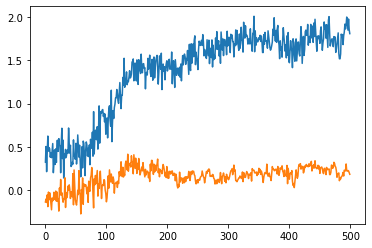

In [52]:
plt.plot(train_rewards)
plt.plot(test_rewards);